###########################

NeuralNetwork Class library

###########################

In [23]:
# import the necessary packages 
import numpy as np

class NeuralNetwork:

    def __init__(self, layers, alpha=0.1):
        # initialize the list of weights matrices, then store the network architecture and learning rate 
        self.W = [] 
        self.layers = layers
        self.alpha = alpha

        # start looping from the index of the first layer but stop before we reach the last two layers 
        for i in np.arange(0, len(layers) - 2):
            # randomly initialize a weight matrix connecting the number of nodes in each respective layer together, adding an extra node for the bias 
            w = np.random.randn(layers[i] + 1, layers[i + 1] + 1) 
            self.W.append(w / np.sqrt(layers[i]))

        # the last two layers are a special case where the input connections need a bias term but the output does not 
        w = np.random.randn(layers[-2] + 1, layers[-1])
        self.W.append(w / np.sqrt(layers[-2]))
    
    def __repr__(self):
        # construct and return a string that represents the network architecture 
        return "NeuralNetwork: {}".format("-".join(str(l) for l in self.layers))
    
    def sigmoid(self, x):
        # compute and return the sigmoid activation value for a given input value 
        return 1.0 / (1 + np.exp(-x))
    
    def sigmoid_deriv(self, x):
        # compute the derivative of the sigmoid function ASSUMING that ‘x‘ has already been passed through the ‘sigmoid‘ function
        return x * (1 - x)

    def train(self, X, y, epochs=1000, displayUpdate=100):
        # insert a column of 1’s as the last entry in the feature matrix -- this little trick allows us to treat the bias as a trainable parameter within the weight matrix
        X = np.c_[X, np.ones((X.shape[0]))]

        # loop over the desired number of epochs
        for epoch in np.arange(0, epochs):
            # loop over each individual data point and train our network on it 
            for (x, target) in zip(X, y):
                self.fit_partial(x, target)
            loss = self.calculate_loss(X, y)
            print("[INFO] epoch={}, loss={:.7f}".format(epoch + 1, loss))

    def fit_partial(self, x, y):
        ########## FEEDFORWARD:

        # construct our list of output activations for each layer as our data point flows through the network; the first activation is a special case -- it’s just the input feature vector itself
        A = [np.atleast_2d(x)]

        # loop over the layers in the network
        for layer in np.arange(0, len(self.W)):
            #feedforward the activation at the current layer by taking the dot product between the activation and the weight matrix -- this is called the "net input" to the current layer 
            net = A[layer].dot(self.W[layer])
            # computing the "net output" is simply applying our nonlinear activation function to the net input 
            out = self.sigmoid(net)
            # once we have the net output, add it to our list of activations 
            A.append(out)

        ########### BACKPROPAGATION:

        # the first phase of backpropagation is to compute the difference between our *prediction* (the final output activation in the activations list) and the true target value
        error = A[-1] - y
        # from here, we need to apply the chain rule and build our list of deltas ‘D‘; the first entry in the deltas is simply the error of the output layer times the derivative of our activation function for the output value
        D = [error * self.sigmoid_deriv(A[-1])]
        # once you understand the chain rule it becomes super easy to implement with a ‘for‘ loop -- simply loop over the layers in reverse order (ignoring the last two since we already have taken them into account)
        for layer in np.arange(len(A) - 2, 0, -1):
            # the delta for the current layer is equal to the delta of the *previous layer* dotted with the weight matrix of the current layer, followed by multiplying the delta by the derivative of the nonlinear activation function for the activations of the current layer
            delta = D[-1].dot(self.W[layer].T)
            delta = delta * self.sigmoid_deriv(A[layer])
            D.append(delta)

        # since we looped over our layers in reverse order we need to reverse the deltas
        D = D[::-1]
        
        # WEIGHT UPDATE PHASE:

        # loop over the layers
        for layer in np.arange(0, len(self.W)):
            # update our weights by taking the dot product of the layer activations with their respective deltas, then multiplying this value by some small learning rate and adding to our weight matrix -- this is where the actual "learning" takes place
            self.W[layer] += -self.alpha * A[layer].T.dot(D[layer])

    def predict(self, X, addBias=True):
        # initialize the output prediction as the input features -- this value will be (forward) propagated through the network to obtain the final prediction
        p = np.atleast_2d(X)
        # check to see if the bias column should be added
        if addBias:
            # insert a column of 1’s as the last entry in the feature matrix (bias) 
            p = np.c_[p, np.ones((p.shape[0]))]
        
        # loop over our layers in the network
        for layer in np.arange(0, len(self.W)):
            # computing the output prediction is as simple as taking the dot product between the current activation value ‘p‘ and the weight matrix associated with the current layer, then passing this value through a nonlinear activation function 
            p = self.sigmoid(np.dot(p, self.W[layer]))

        # return the predicted value 
        return p

    def calculate_loss(self, X, targets):
        # make predictions for the input data points then compute the loss
        targets = np.atleast_2d(targets)
        predictions = self.predict(X, addBias=False)
        loss = 0.5 * np.sum((predictions - targets) ** 2)

        # return the loss
        return loss

##################################

Training and Testing data on Model (Main File)

##################################

############# Importing libraries ##############

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.preprocessing import LabelBinarizer 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn import datasets
import pathlib
from pathlib import Path
import PIL
from PIL import Image
import os
import math

############# Functions for ploting prediction graphs ##############

In [28]:
# Code to visualize results
# go through each line of code and try to understand what it is doing

def find_labels(prediction_array, true_label_array):
  true_index = 0
  predicted_index = 0
  max = prediction_array[0]
  for j in range(len(true_label_array)):
    if true_label_array[j] == 1:
        true_index = j
    if prediction_array[j] > max:
        max = prediction_array[j]
        predicted_index = j

  return true_index,predicted_index


def plot_image(prediction_array, true_label_array, img):
  
  true_label, predicted_label = find_labels(prediction_array,true_label_array)
  img_length = int(math.sqrt(len(img)))
  img = img.reshape(img_length,img_length)

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.gray_r, interpolation="nearest")

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(prediction_array), # need to put in actual percentage confidence here
                                class_names[true_label]),
                                color=color)

def plot_value_array(prediction_array, true_label_array):
  
  true_label, predicted_label = find_labels(prediction_array,true_label_array)

  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), prediction_array, color="#777777")
  plt.ylim([0, 1])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

############# Training and Testing model on MNIST dataset ##############

[INFO] loading MNIST (sample) dataset...
[INFO] samples: 1797, dim: 64
[INFO] training network...
[INFO] NeuralNetwork: 64-32-16-10
[INFO] epoch=1, loss=605.2276977
[INFO] epoch=2, loss=603.3131232
[INFO] epoch=3, loss=600.4056342
[INFO] epoch=4, loss=594.9850536
[INFO] epoch=5, loss=581.7129788
[INFO] epoch=6, loss=541.0765882
[INFO] epoch=7, loss=470.5177906
[INFO] epoch=8, loss=401.0138083
[INFO] epoch=9, loss=339.6184509
[INFO] epoch=10, loss=293.9700895
[INFO] epoch=11, loss=261.4004321
[INFO] epoch=12, loss=234.4866449
[INFO] epoch=13, loss=208.4519286
[INFO] epoch=14, loss=182.8531267
[INFO] epoch=15, loss=158.3237554
[INFO] epoch=16, loss=135.1360247
[INFO] epoch=17, loss=114.1509476
[INFO] epoch=18, loss=96.9977489
[INFO] epoch=19, loss=83.9653808
[INFO] epoch=20, loss=74.0850991
[INFO] epoch=21, loss=66.3903921
[INFO] epoch=22, loss=60.2342562
[INFO] epoch=23, loss=55.1991153
[INFO] epoch=24, loss=51.0040322
[INFO] epoch=25, loss=47.4516446
[INFO] epoch=26, loss=44.3987064
[I

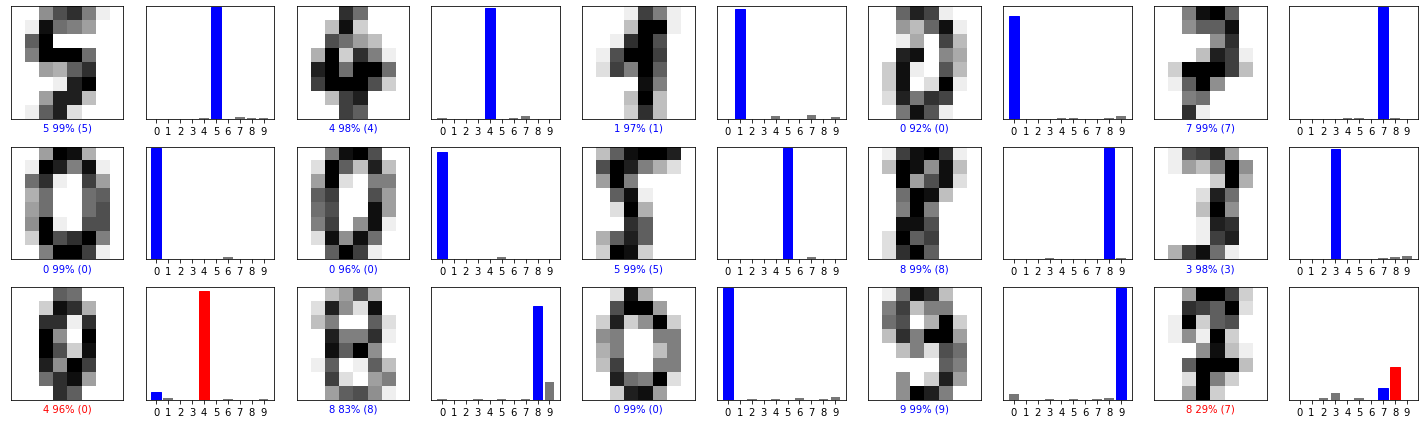

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        50
           1       1.00      0.96      0.98        46
           2       0.98      1.00      0.99        41
           3       0.96      0.96      0.96        45
           4       0.94      1.00      0.97        49
           5       0.96      0.92      0.94        48
           6       0.95      1.00      0.98        40
           7       1.00      0.96      0.98        49
           8       0.91      1.00      0.96        32
           9       0.96      0.94      0.95        50

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



In [29]:
# load the MNIST dataset and apply min/max scaling to scale the 9 # pixel intensity values to the range [0, 1] (each image is represented by an 8 x 8 = 64-dim feature vector)

print("[INFO] loading MNIST (sample) dataset...")
digits = datasets.load_digits()
data = digits.data.astype("float")
data = (data - data.min()) / (data.max() - data.min())
print("[INFO] samples: {}, dim: {}".format(data.shape[0],data.shape[1]))

# construct the training and testing splits
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
(trainX, testX, trainY, testY) = train_test_split(data, digits.target, test_size=0.25)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# train the network
print("[INFO] training network...")
MNISTmodel = NeuralNetwork([trainX.shape[1], 32, 16, 10])
print("[INFO] {}".format(MNISTmodel))
MNISTmodel.train(trainX, trainY, epochs=50)

# evaluate the network
print("[INFO] evaluating network...")
predictions = MNISTmodel.predict(testX)


# Plot the first X (in our case, we did 5 X 3) test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

num_rows = 3
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  
  #review the plot_image function above
  plot_image(predictions[i], testY[i], testX[i])

  plt.subplot(num_rows, 2*num_cols, 2*i+2)

  #review the plot_value_array function above
  plot_value_array(predictions[i], testY[i])

plt.tight_layout()
plt.show()

#summary of performance
predictions = predictions.argmax(axis=1)
print(classification_report(testY.argmax(axis=1), predictions))

############# Training and Testing model on Our dataset ##############

In [30]:
# Connect the google drive to read the data

from google.colab import drive
drive.mount('/content/gdrive/')

%cd gdrive/MyDrive

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive'
/content/gdrive/MyDrive


############# Function to create the data set from images ##############

In [31]:
def createDataSet(dir, class_names):
    dataList = []   # data list
    labelList = []  # respective label list to the data

    dataSetDir = Path(dir)  # path directory
    i = -1

    allFolders = os.listdir(dataSetDir)
    for curFolder in allFolders:
        # Opening a folder to read the data
        i = i + 1
        curDataPath = dir + "/Sample00" + str(i+1)
        curDataDir = Path(curDataPath)
        allData = os.listdir(curDataDir)
    
        for curData in allData:
            # Read an image and it's respective label
            data = image.imread((curDataPath+"/"+curData), "PNG")
            data = np.append([], np.array(data))
            
            # Store it in the list with correct format
            dataList.append(data)
            label = np.zeros(len(class_names))
            label[i] = 1
            labelList.append(label)
    
    # Make our data list a numpy array for faster computation
    dataList = np.array(dataList)
    labelList = np.array(labelList)

    return dataList, labelList

############# Training and Testing model on our local dataset ##############

We have  118 images in our training dataset.
We have  10 images in our training dataset.

[INFO] training network...
[INFO] NeuralNetwork: 16384-128-64-10
[INFO] epoch=1, loss=64.7545325
[INFO] epoch=2, loss=65.6741898
[INFO] epoch=3, loss=69.0283086
[INFO] epoch=4, loss=70.4592833
[INFO] epoch=5, loss=71.9515997
[INFO] epoch=6, loss=73.1597710
[INFO] epoch=7, loss=74.5239845
[INFO] epoch=8, loss=74.8424818
[INFO] epoch=9, loss=74.3104957
[INFO] epoch=10, loss=73.8979713
[INFO] epoch=11, loss=73.5013604
[INFO] epoch=12, loss=72.8364847
[INFO] epoch=13, loss=71.6566181
[INFO] epoch=14, loss=71.5059977
[INFO] epoch=15, loss=71.0596394
[INFO] epoch=16, loss=70.4429028
[INFO] epoch=17, loss=69.0133592
[INFO] epoch=18, loss=66.6573939
[INFO] epoch=19, loss=63.7003261
[INFO] epoch=20, loss=61.2508896
[INFO] epoch=21, loss=60.6411876
[INFO] epoch=22, loss=59.3092408
[INFO] epoch=23, loss=56.3738818
[INFO] epoch=24, loss=54.2216122
[INFO] epoch=25, loss=52.2558252
[INFO] epoch=26, loss=50.0660

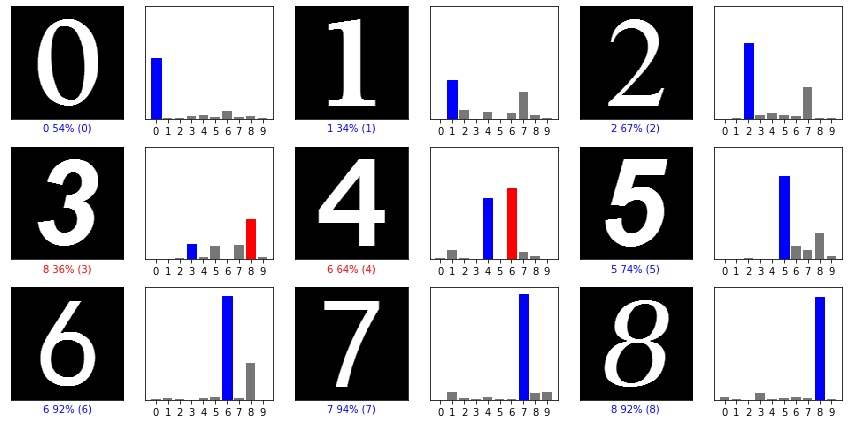

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         1

    accuracy                           0.80        10
   macro avg       0.70      0.80      0.73        10
weighted avg       0.70      0.80      0.73        10



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
trainingDataPath = "Courses/CS340/Project/TrainingData"
testingDataPath = "Courses/CS340/Project/TestingData"

trainingSet, trainingLabel = createDataSet(trainingDataPath, class_names)
trainingSet = trainingSet/255

testingSet, testingLabel = createDataSet(testingDataPath, class_names)
testingSet = testingSet/255

print("We have ",len(trainingSet), "images in our training dataset.")
print("We have ",len(testingSet), "images in our training dataset.")
print()

layers = [128*128] + [128, 64] + [10]
# train the network
print("[INFO] training network...")
OCRmodel = NeuralNetwork(layers)
print("[INFO] {}".format(OCRmodel))
OCRmodel.train(trainingSet, trainingLabel, epochs=50)

# evaluate the network
print("[INFO] evaluating network...")
predictions = OCRmodel.predict(testingSet)


# Plot the first X (in our case, we did 5 X 3) test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  
  #review the plot_image function above
  plot_image(predictions[i], testingLabel[i], testingSet[i])

  plt.subplot(num_rows, 2*num_cols, 2*i+2)

  #review the plot_value_array function above
  plot_value_array(predictions[i], testingLabel[i])

plt.tight_layout()
plt.show()

#summary of performance
predictions = predictions.argmax(axis=1)
print(classification_report(testingLabel.argmax(axis=1), predictions))